# Смена директории


In [6]:
%cd ..

/Users/macbook/Desktop/Project/Year_project


# Импорт библиотек


In [7]:
import logging
import warnings


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import joblib
import shap
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from catboost import CatBoostClassifier


from utils.dev_utils import get_pool
from utils.pipeline_utils import CustomPreprocessor
from utils.metrics import MetricCalculator, metric_funcs
from utils.style.styler import style_metrics
from utils.style.html_output import print_multiple_html
from utils.plot_utils import plot_gini_by_period_styled, plot_roc_by_masks

In [8]:
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings('ignore')
sns.set_palette('bright')


pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [9]:
%load_ext autoreload
%autoreload 2
%aimport utils.plot_utils
%aimport utils.eda_utils
%aimport utils.style_utils
%aimport utils.psi
%aimport utils.style.styler

# Входные данные


## Загрузка данных


In [10]:
data = pd.read_parquet('./data/processed/data.pqt')

data.shape

(1097231, 494)

## Валидные переменные


In [11]:
path = r'./docs/valid_features.xlsx'
valid_features_data = pd.read_excel(path, index_col=False)

## Конфиги/константы


In [13]:
TARGET = 'target'
DATE_MONTH = 'date_month'
DATE_QUARTAL = 'date_quartal'

# Берем порог отсечения по gini - 0.3
FEATURES = valid_features_data.loc[
    (valid_features_data['valid_flag'] == 1) & 
    ((valid_features_data['iv'] > 0.9) | (valid_features_data['gini'].isna()))]['attribute'].values
CAT_FEATURES = list(set(FEATURES) & set(data.select_dtypes(include=["object", "category"]).columns))
NUM_FEATURES = list(set(FEATURES) & set(data.select_dtypes(include=["number"]).columns))

TRAIN_MASK = (data['sample_type'] == 'TRAIN')
TEST_MASK = (data['sample_type'] == 'TEST')
OOT_MASK = (data['sample_type'] == 'OOT')

DEV_MASK = (data['competition_sample_type'] == 'TRAIN')

In [14]:
print_multiple_html(
    ('Кол-во переменных: ', len(FEATURES)),
    ('Кол-во категориальных переменных: ', len(CAT_FEATURES))
)

In [98]:
metr_funcs = {
    'roc_auc': metric_funcs.roc_auc_score_nan,
    'gini': metric_funcs.gini_score_nan,
    'precision': metric_funcs.precision,
    'recall': metric_funcs.recall
}

stats_funcs = {
    'obs_cnt': lambda y_true, data: len(y_true),
    'target_cnt': lambda y_true, data: sum(y_true),
    'DR': lambda y_true, data: sum(y_true) / len(y_true)
}

# Класс для расчета метрик
metr_calc = MetricCalculator(metr_funcs=metr_funcs, stats_funcs=stats_funcs)


STYLE_CONFIG = {
    'percent_cols': ['gini', 'roc_auc', 'DR', 'precision', 'recall'],
    'int_cols': ['obs_cnt', 'target_cnt'],
    'gradient_cols': ['gini', 'roc_auc', 'precision', 'recall'],
    'gradient_cmap': 'RdYlGn',
}

In [99]:
def metrics_split(data, group_cols, metr_calc, pred_cols=['lg_model_preds'], target='target', asc=True):
    """Упрощенный интерфес для расчета метрик"""

    metr_split = metr_calc.calculate(data, true_col=target, pred_cols=pred_cols, group_cols=group_cols)
    metr_split = (
        metr_split
        .sort_values(by=group_cols, ascending=asc)
        .set_index(group_cols)
    )
    
    return metr_split

# Обучение LogReg


In [17]:
default_params = {
    'penalty': 'l1',
    'dual': False,
    'tol': 0.0001,
    'C': 1.0,
    'fit_intercept': True,
    'intercept_scaling': 1,
    'solver': 'saga',
    'max_iter': 100,
    'random_state': 42,
}


preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), NUM_FEATURES),
        ('cat', CatBoostEncoder(), CAT_FEATURES),
    ], 
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(**default_params))
])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
data['lg_model_preds'] = pipeline.predict_proba(data[FEATURES])[:, 1]

In [43]:
# Выводим топ-20
model_from_pipeline = pipeline.named_steps['model']

coef_df_scaling = pd.DataFrame({
    'feature': FEATURES,
    'coef': abs(model_from_pipeline.coef_[0])
})

coef_df_scaling.sort_values(by='coef', ascending=False).head(20)

,feature,coef
21,V158,2.63
22,V188,0.98
23,V189,0.89
28,V246,0.58
8,M4,0.46
30,V258,0.45
12,M8,0.40
13,M9,0.40
32,DeviceInfo,0.39
3,P_emaildomain,0.35


## Метрики


In [44]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,lg_model_preds,73.9%,47.7%,83.9%,15.7%,350 849,12 166,3.5%
TEST,lg_model_preds,73.3%,46.6%,84.6%,15.3%,150 365,5 383,3.6%
OOT,lg_model_preds,73.6%,47.1%,87.5%,16.6%,89 326,3 114,3.5%


In [45]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,lg_model_preds,72.1%,44.1%,72.4%,13.5%,134 339,3 401,2.5%
2020-02,lg_model_preds,76.5%,52.9%,90.4%,17.6%,86 467,3 469,4.0%
2020-03,lg_model_preds,75.1%,50.2%,88.4%,16.3%,95 121,3 832,4.0%
2020-04,lg_model_preds,74.3%,48.5%,83.1%,16.9%,98 615,3 898,4.0%
2020-05,lg_model_preds,71.8%,43.5%,86.6%,13.2%,86 672,2 949,3.4%
2020-06,lg_model_preds,73.4%,46.8%,86.9%,16.5%,86 572,2 995,3.5%
2020-07,lg_model_preds,78.3%,56.5%,100.0%,20.2%,2 754,119,4.3%


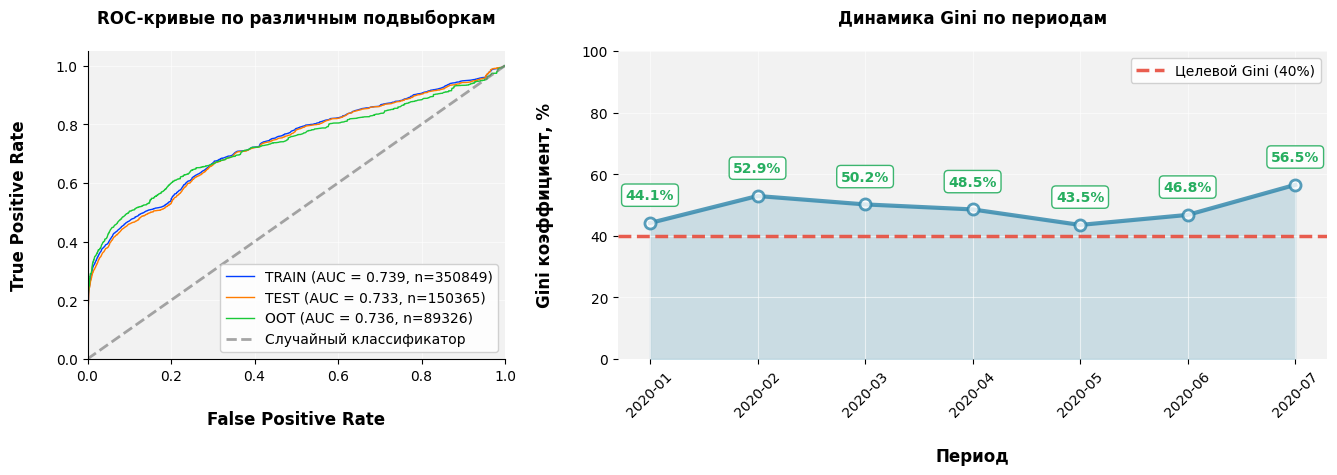

In [46]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'lg_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

## Подбор гиперпараметров для логистической регрессии


In [47]:
def objective(trial):
    params = {
        'penalty': trial.suggest_categorical("penalty", ["l1", "l2"]),
        'tol': trial.suggest_float("tol", 0.0001, 0.01, log=True),
        'C': trial.suggest_float("C", 1.0, 10.0, log=True),
        'solver': trial.suggest_categorical("solver", ["liblinear", "saga"]),
        'fit_intercept': True,
        'intercept_scaling': 1,
        'dual': False,
        'max_iter': 100,
        'random_state': 42
        }

    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(**params))
    ])

    pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])
    
    
    roc_auc = roc_auc_score(data[TEST_MASK][TARGET], pipeline.predict_proba(data[TEST_MASK][FEATURES])[:, 1])
    return roc_auc

In [37]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20, show_progress_bar=False)

[I 2025-12-23 23:28:39,535] A new study created in memory with name: no-name-20059fbc-5a3c-4c69-b90f-9ad9af172e14
[I 2025-12-23 23:28:44,104] Trial 0 finished with value: 0.7524425902391803 and parameters: {'penalty': 'l2', 'tol': 0.0029106359131330704, 'C': 3.968793330444372, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7524425902391803.
[I 2025-12-23 23:28:55,637] Trial 1 finished with value: 0.7330857816929817 and parameters: {'penalty': 'l2', 'tol': 0.0015930522616241021, 'C': 5.105903209394756, 'solver': 'saga'}. Best is trial 0 with value: 0.7524425902391803.
[I 2025-12-23 23:29:08,704] Trial 2 finished with value: 0.7330918250934302 and parameters: {'penalty': 'l1', 'tol': 0.0002310201887845295, 'C': 1.5254729458052607, 'solver': 'saga'}. Best is trial 0 with value: 0.7524425902391803.
[I 2025-12-23 23:29:21,620] Trial 3 finished with value: 0.7330984835330425 and parameters: {'penalty': 'l1', 'tol': 0.0016738085788752138, 'C': 1.3787764619353768, 'solver': 'saga'}. Bes

In [39]:
final_params_lg_model = {**default_params, **study.best_params}
final_params_lg_model

{'penalty': 'l1',
 'dual': False,
 'tol': 0.00013492834268013249,
 'C': 8.88966790701893,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'solver': 'liblinear',
 'max_iter': 100,
 'random_state': 42}

In [19]:
# Обучение модели с подобранными гиперпараметрами
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(**final_params_lg_model))
])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

data['lg_model_optuna_preds'] = pipeline.predict_proba(data[FEATURES])[:, 1]

In [20]:
# Метрики модели с подобранными гиперпараметрами
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_optuna_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,lg_model_optuna_preds,76.3%,52.6%,78.8%,21.7%,350 849,12 166,3.5%
TEST,lg_model_optuna_preds,76.0%,52.1%,77.1%,20.8%,150 365,5 383,3.6%
OOT,lg_model_optuna_preds,76.2%,52.4%,81.2%,19.4%,89 326,3 114,3.5%


In [22]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='lg_model_optuna_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,lg_model_optuna_preds,73.1%,46.2%,62.7%,17.7%,134 339,3 401,2.5%
2020-02,lg_model_optuna_preds,79.6%,59.1%,84.9%,22.7%,86 467,3 469,4.0%
2020-03,lg_model_optuna_preds,78.5%,57.0%,84.0%,25.4%,95 121,3 832,4.0%
2020-04,lg_model_optuna_preds,76.3%,52.6%,79.6%,21.8%,98 615,3 898,4.0%
2020-05,lg_model_optuna_preds,75.9%,51.9%,79.3%,18.7%,86 672,2 949,3.4%
2020-06,lg_model_optuna_preds,76.1%,52.2%,80.5%,19.2%,86 572,2 995,3.5%
2020-07,lg_model_optuna_preds,80.1%,60.3%,96.8%,25.2%,2 754,119,4.3%


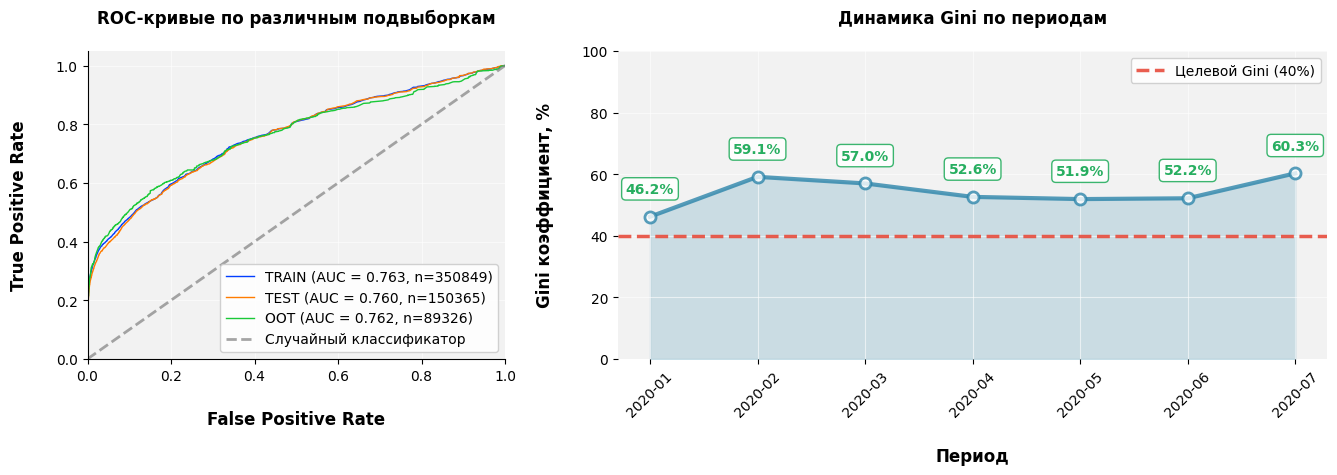

In [23]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'lg_model_optuna_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

# Обучение KNN


In [24]:
default_params = {
    'n_neighbors': 100,        # Количество ближайших соседей для классификации
    'weights': 'uniform',      # Все соседи имеют одинаковый вес при голосовании
    'metric': 'manhattan',     # Используется манхэттенское расстояние (L1-норма)
    'algorithm': 'kd_tree',    # Алгоритм для построения пространственного индекса
    'leaf_size': 200,          # Минимальный размер листа в дереве (точки прекращения разбиения)   
    'p': 1,                    # Для manhattan (p=1) 
        
    
}

knn_model = KNeighborsClassifier(**default_params)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),    
    ('model', knn_model)
])

In [58]:
pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

,steps,"[('preprocessor', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
data.loc[DEV_MASK, 'knn_model_preds'] = pipeline.predict_proba(data.loc[DEV_MASK][FEATURES])[:, 1]

## Метрики


In [60]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='knn_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,knn_model_preds,78.7%,57.3%,83.0%,18.8%,350 849,12 166,3.5%
TEST,knn_model_preds,77.2%,54.4%,82.5%,18.3%,150 365,5 383,3.6%
OOT,knn_model_preds,77.7%,55.4%,83.5%,19.5%,89 326,3 114,3.5%


In [61]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='knn_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,knn_model_preds,75.6%,51.2%,70.1%,16.7%,134 339,3 401,2.5%
2020-02,knn_model_preds,77.7%,55.4%,88.8%,20.3%,86 467,3 469,4.0%
2020-03,knn_model_preds,79.3%,58.5%,88.3%,22.5%,95 121,3 832,4.0%
2020-04,knn_model_preds,78.4%,56.8%,83.1%,17.4%,98 615,3 898,4.0%
2020-05,knn_model_preds,81.0%,62.0%,83.3%,15.5%,86 672,2 949,3.4%
2020-06,knn_model_preds,77.7%,55.4%,83.2%,19.3%,86 572,2 995,3.5%
2020-07,knn_model_preds,77.7%,55.4%,90.9%,25.2%,2 754,119,4.3%


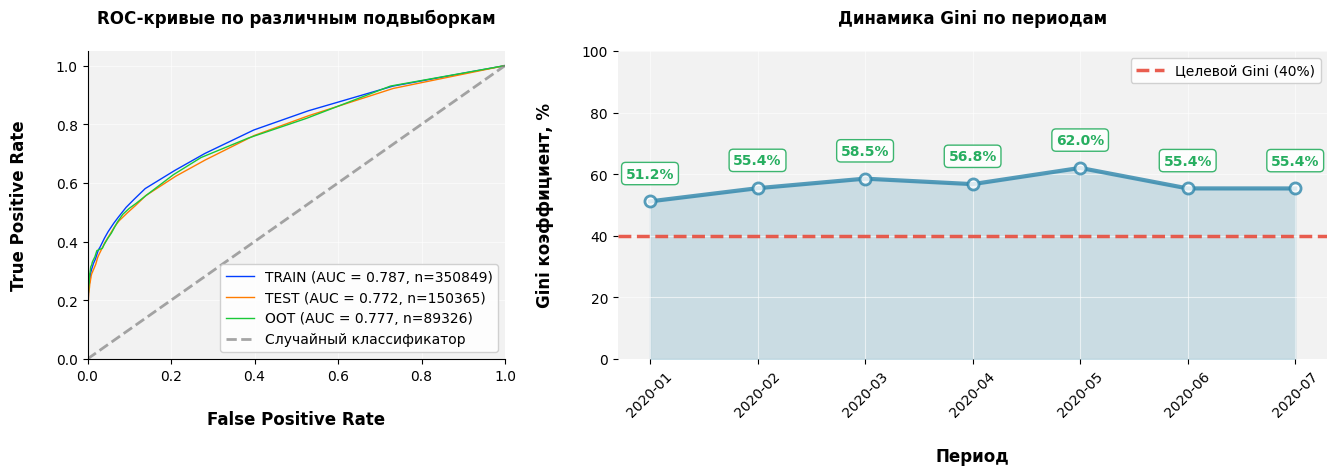

In [62]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'knn_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

## Подбор гиперпараметров для KNN


In [ ]:

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_int("n_neighbors", 50, 500, 10),        # Количество ближайших соседей для классификации
        'weights': trial.suggest_categorical("weights", ['uniform','distance']),      #  вес соседей
        'leaf_size': trial.suggest_int("leaf_size", 50, 500, 10),          # Минимальный размер листа в дереве (точки прекращения разбиения)   
        'algorithm': 'kd_tree',    # Алгоритм для построения пространственного индекса
        'metric': 'manhattan',     # Используется манхэттенское расстояние (L1-норма)
        'p': 1                     # Для manhattan (p=1)     
        }
    


    knn_model = KNeighborsClassifier(**params)

    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),    
    ('model', knn_model)
    ])

    pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])
    
    
    roc_auc = roc_auc_score(data[TEST_MASK][TARGET], pipeline.predict_proba(data[TEST_MASK][FEATURES])[:, 1])
    return roc_auc

In [26]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-12-24 13:56:51,646] A new study created in memory with name: no-name-1309a8dd-f75c-4c8f-b0bb-651880df3d4c
[I 2025-12-24 13:57:13,070] Trial 0 finished with value: 0.7764285205212673 and parameters: {'n_neighbors': 220, 'weights': 'uniform', 'leaf_size': 320}. Best is trial 0 with value: 0.7764285205212673.
[I 2025-12-24 13:57:36,543] Trial 1 finished with value: 0.7728600133217995 and parameters: {'n_neighbors': 120, 'weights': 'uniform', 'leaf_size': 440}. Best is trial 0 with value: 0.7764285205212673.
[I 2025-12-24 13:58:11,638] Trial 2 finished with value: 0.7777305430547492 and parameters: {'n_neighbors': 320, 'weights': 'uniform', 'leaf_size': 490}. Best is trial 2 with value: 0.7777305430547492.
[I 2025-12-24 13:58:37,017] Trial 3 finished with value: 0.7808960874855078 and parameters: {'n_neighbors': 430, 'weights': 'uniform', 'leaf_size': 130}. Best is trial 3 with value: 0.7808960874855078.
[I 2025-12-24 13:58:56,266] Trial 4 finished with value: 0.7754732327229548 an

In [27]:
final_params_knn_model = {**default_params, **study.best_params}
final_params_knn_model

{'n_neighbors': 330,
 'weights': 'distance',
 'metric': 'manhattan',
 'algorithm': 'kd_tree',
 'leaf_size': 210,
 'p': 1}

In [ ]:
# Обучение модели с подобранными гиперпараметрами
knn_model = KNeighborsClassifier(**final_params_knn_model)

pipeline = Pipeline([
('preprocessor', preprocessor),
('pca', PCA(n_components=20)),    
('model', knn_model)
])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])


data.loc[DEV_MASK, 'knn_model_optuna_preds'] = pipeline.predict_proba(data.loc[DEV_MASK][FEATURES])[:, 1]

In [34]:
# Метрики модели с подобранными гиперпараметрами
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='knn_model_optuna_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,knn_model_optuna_preds,80.1%,60.2%,88.5%,23.3%,350 849,12 166,3.5%
TEST,knn_model_optuna_preds,78.5%,57.0%,81.3%,20.0%,150 365,5 383,3.6%
OOT,knn_model_optuna_preds,78.6%,57.3%,79.1%,20.0%,89 326,3 114,3.5%


In [40]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='knn_model_optuna_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,knn_model_optuna_preds,76.3%,52.6%,73.7%,19.4%,134 339,3 401,2.5%
2020-02,knn_model_optuna_preds,79.5%,59.1%,87.9%,22.8%,86 467,3 469,4.0%
2020-03,knn_model_optuna_preds,80.4%,60.9%,89.5%,25.9%,95 121,3 832,4.0%
2020-04,knn_model_optuna_preds,79.9%,59.9%,89.1%,22.5%,98 615,3 898,4.0%
2020-05,knn_model_optuna_preds,82.9%,65.7%,92.8%,20.0%,86 672,2 949,3.4%
2020-06,knn_model_optuna_preds,78.7%,57.5%,78.5%,19.8%,86 572,2 995,3.5%
2020-07,knn_model_optuna_preds,76.4%,52.9%,91.2%,26.1%,2 754,119,4.3%


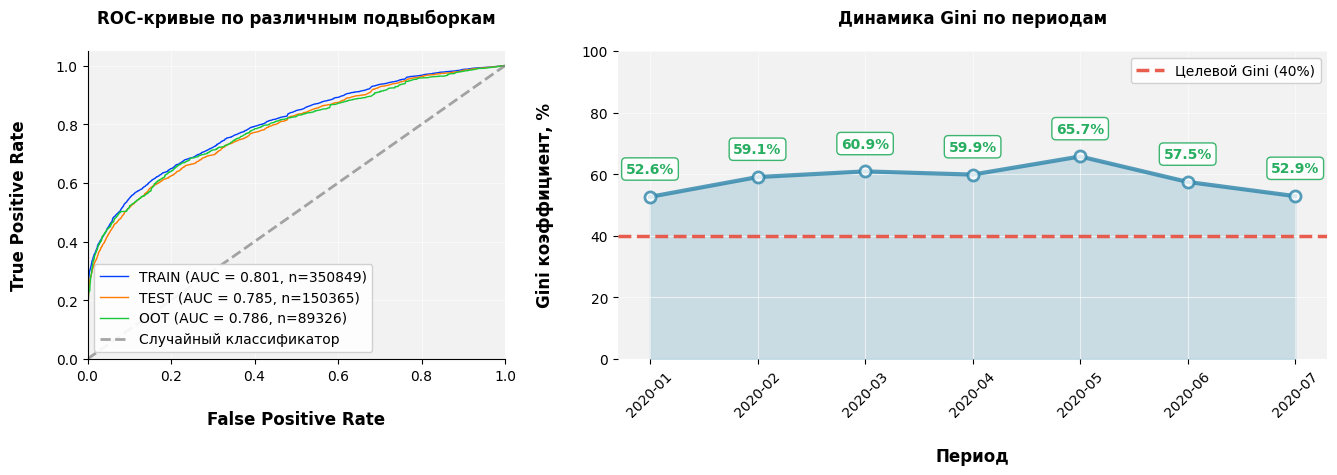

In [36]:
# Графики распределения таргета по выборкам модели с подобранными гиперпараметрами
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={
                         'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'knn_model_optuna_preds', masks_dict,
                  figsize=(8, 4), palette='bright',
                  title='ROC-кривые по различным подвыборкам',
                  ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                           figsize=(8, 4),
                           target_gini=40,
                           title='Динамика Gini по периодам',
                           ax=ax)

# Обучение SVM


In [96]:
# Параметры SVM для задачи аномалий
default_params = {
    'C': 1,             
    'kernel': 'rbf',           
    'gamma': 'scale',
    'class_weight': 'balanced',  
    'probability': True,
    'cache_size': 2000,
    'max_iter': 1000,
    'random_state': 42
}


# Создаем SVM модель
svm_model = SVC(**default_params)

# Пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),    
    ('model', svm_model)
])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

,steps,"[('preprocessor', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [97]:
data.loc[DEV_MASK, 'svm_model_preds'] = pipeline.predict_proba(data.loc[DEV_MASK][FEATURES])[:, 1]

## Метрики


In [ ]:
# переопределение порога классификации для расчета precision и recall
threshold_svm = data.loc[DEV_MASK, 'svm_model_preds'].quantile(0.95)

metr_funcs = {
    'roc_auc': metric_funcs.roc_auc_score_nan,
    'gini': metric_funcs.gini_score_nan,
    'precision': lambda y_true, y_pred: metric_funcs.precision(y_true, y_pred,  threshold=threshold_svm),
    'recall': lambda y_true, y_pred: metric_funcs.recall(y_true, y_pred, threshold=threshold_svm)
}

# Класс для расчета метрик
metr_calc = MetricCalculator(metr_funcs=metr_funcs, stats_funcs=stats_funcs)

In [115]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='svm_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,svm_model_preds,70.1%,40.2%,17.3%,24.7%,350 849,12 166,3.5%
TEST,svm_model_preds,69.9%,39.7%,17.0%,24.2%,150 365,5 383,3.6%
OOT,svm_model_preds,71.7%,43.4%,19.5%,28.2%,89 326,3 114,3.5%


In [116]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='svm_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,svm_model_preds,65.1%,30.2%,5.7%,23.4%,134 339,3 401,2.5%
2020-02,svm_model_preds,73.5%,47.1%,34.1%,26.7%,86 467,3 469,4.0%
2020-03,svm_model_preds,72.7%,45.4%,32.7%,25.5%,95 121,3 832,4.0%
2020-04,svm_model_preds,71.7%,43.3%,32.9%,24.4%,98 615,3 898,4.0%
2020-05,svm_model_preds,68.6%,37.1%,26.0%,22.3%,86 672,2 949,3.4%
2020-06,svm_model_preds,71.6%,43.3%,19.2%,28.0%,86 572,2 995,3.5%
2020-07,svm_model_preds,73.1%,46.3%,34.3%,31.1%,2 754,119,4.3%


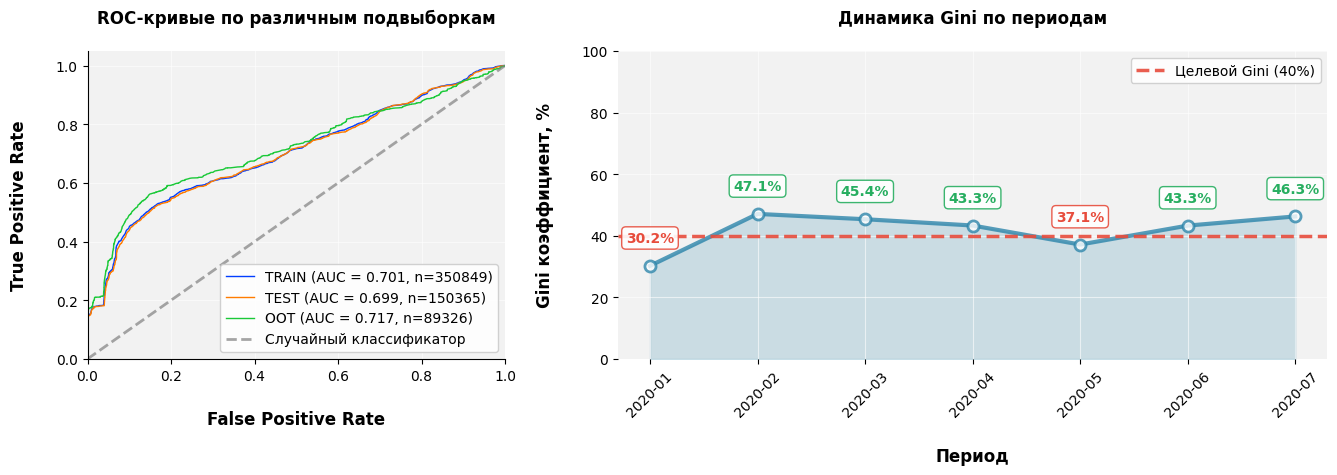

In [117]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'svm_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

## Подбор гиперпараметров для SVM


In [120]:
def objective(trial):
    # Параметры SVM для задачи аномалий
    params = {
        'C': trial.suggest_float('C', 0, 4),             
        'kernel': trial.suggest_categorical('kernel', ['rbf','linear', 'poly', 'sigmoid']), 
        'gamma': 'scale',
        'class_weight': 'balanced',  
        'probability': True,
        'cache_size': 2000,
        'max_iter': 1000,
        'random_state': 42
    }


    svm_model = SVC(**params)

    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),    
    ('model', svm_model)
    ])

    pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])
    
    
    roc_auc = roc_auc_score(data[TEST_MASK][TARGET], pipeline.predict_proba(data[TEST_MASK][FEATURES])[:, 1])
    return roc_auc

In [121]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-12-24 17:50:12,814] A new study created in memory with name: no-name-d417623c-849c-48f0-8b58-7796f99d8802
[I 2025-12-24 17:51:17,682] Trial 0 finished with value: 0.4042074932973609 and parameters: {'C': 1.49816047538945, 'kernel': 'rbf'}. Best is trial 0 with value: 0.4042074932973609.
[I 2025-12-24 17:52:03,474] Trial 1 finished with value: 0.3488619038548074 and parameters: {'C': 0.6239780813448106, 'kernel': 'linear'}. Best is trial 0 with value: 0.4042074932973609.
[I 2025-12-24 17:53:08,757] Trial 2 finished with value: 0.6040584568790904 and parameters: {'C': 0.08233797718320979, 'kernel': 'rbf'}. Best is trial 2 with value: 0.6040584568790904.
[I 2025-12-24 17:53:56,380] Trial 3 finished with value: 0.3366358363080749 and parameters: {'C': 0.7336180394137353, 'kernel': 'linear'}. Best is trial 2 with value: 0.6040584568790904.
[I 2025-12-24 17:54:58,001] Trial 4 finished with value: 0.40637353566126355 and parameters: {'C': 2.447411578889518, 'kernel': 'sigmoid'}. Best 

In [122]:
final_params_svm_model = {**default_params, **study.best_params}
final_params_svm_model

{'C': 0.08233797718320979,
 'kernel': 'rbf',
 'gamma': 'scale',
 'class_weight': 'balanced',
 'probability': True,
 'cache_size': 2000,
 'max_iter': 1000,
 'random_state': 42}

In [123]:
# Обучение модели с подобранными гиперпараметрами
svm_model = SVC(**final_params_svm_model)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20)),    
    ('model', svm_model)
    ])

pipeline.fit(data.loc[TRAIN_MASK][FEATURES], data.loc[TRAIN_MASK][TARGET])

data.loc[DEV_MASK, 'svm_model_optuna_preds'] = pipeline.predict_proba(data.loc[DEV_MASK][FEATURES])[:, 1]

In [131]:
# переопределение порога классификации для расчета precision и recall
threshold_svm = data.loc[DEV_MASK, 'svm_model_optuna_preds'].quantile(0.95)

# Метрики модели с подобранными гиперпараметрами
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='svm_model_optuna_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,svm_model_optuna_preds,61.2%,22.5%,17.1%,24.5%,350 849,12 166,3.5%
TEST,svm_model_optuna_preds,60.4%,20.8%,16.8%,23.9%,150 365,5 383,3.6%
OOT,svm_model_optuna_preds,62.9%,25.8%,19.4%,27.8%,89 326,3 114,3.5%


In [132]:
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='svm_model_optuna_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,svm_model_optuna_preds,56.5%,12.9%,5.7%,23.2%,134 339,3 401,2.5%
2020-02,svm_model_optuna_preds,60.8%,21.5%,33.7%,26.5%,86 467,3 469,4.0%
2020-03,svm_model_optuna_preds,65.4%,30.7%,32.3%,25.3%,95 121,3 832,4.0%
2020-04,svm_model_optuna_preds,62.3%,24.7%,32.6%,24.3%,98 615,3 898,4.0%
2020-05,svm_model_optuna_preds,60.9%,21.7%,25.6%,21.8%,86 672,2 949,3.4%
2020-06,svm_model_optuna_preds,62.7%,25.5%,19.1%,27.6%,86 572,2 995,3.5%
2020-07,svm_model_optuna_preds,66.7%,33.4%,34.9%,31.9%,2 754,119,4.3%


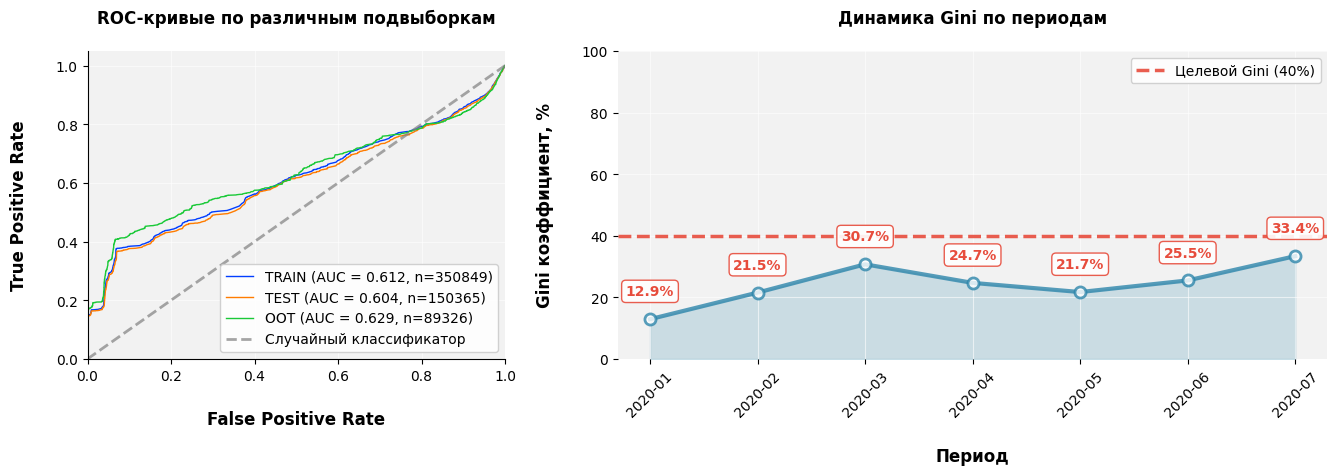

In [133]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'svm_model_optuna_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)